## NEWS Dataset - Fake or Real NEWS Classifier


Please find the dataset from the link - https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

#### Points to be considered:
    
1. Import Libraries/Dataset
    * Import the required libraries and the dataset (use Google Drive if required).
    * Check the GPU available (recommended- use free GPU provided by Google Colab).
2. Data Visualization
    * Print at least two texts from each class (fake & real) of the dataset, for a sanity check that labels match the text.
    * Plot a bar graph of class distribution in a dataset. Each bar depicts the number of texts belonging to a particular class. (recommended - matplotlib/seaborn libraries)
    * Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.
    * Print the shapes of train and test data.
3. Data Pre-processing
    * Need for this Step - Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step. The discussion of different ways of handling this step is out of the scope of this assignment.
    * Please use this pre-trained embedding layer (https://tfhub.dev/google/nnlm-en-dim128/1) from TensorFlow hub for this assignment. This link also has a code snippet on how to convert a sentence to a vector. Refer to that for further clarity on this subject.
    * Bring the train and test data in the required format.
4. Model Building
    * Sequential Model layers - Use AT LEAST 3 hidden layers with appropriate input for each. 
    * Choose the best number for hidden units and give reasons.
    * Add L2 regularization to all the layers.
    * Add one layer of dropout at the appropriate position and give reasons.
    * Choose the appropriate activation function for all the layers.
    * Print the model summary.

5. Model Compilation
    * Compile the model with the appropriate loss function.
    * Use an appropriate optimizer. 
    * Give reasons for the choice of learning rate and its value.
    * Use accuracy as a metric.
6. Model Training
    * Train the model for an appropriate number of epochs. 
    * Print the train and validation accuracy and loss for each epoch. 
    * Use the appropriate batch size.
    * Plot the loss and accuracy history graphs for both train and validation set. 
    * Print the total time taken for training.
7. Model Evaluation
    * Print the final train and validation loss and accuracy. 
    * Print confusion matrix and classification report for the validation dataset. 
    * Analyse and report the best and worst performing class.
    * Print the two most incorrectly classified texts for each class in the test dataset.
8. Hyperparameter Tuning
     * Build two more models by changing the following hyperparameters one at a time. 
     * Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

* **Optimiser**: Use a different optimizer with the appropriate LR value
* **Batch Size**: Change the value of batch size in model training

Write a comparison between each model and give reasons for the difference in results.

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [4]:
df_fake = pd.read_csv('Fake.csv')
df_fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [5]:
df_true = pd.read_csv('True.csv')
df_true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


#### setting label 1 for TRUE news

In [6]:
df_true['label'] = 1
df_true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


#### setting label 0 for FAKE news

In [7]:
df_fake['label'] = 0
df_fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
label_map = {0:"FAKE", 1:"REAL"}

In [9]:
# merging both fake and true datasets
df_whole = pd.concat([df_fake, df_true])

In [10]:
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [11]:
print(df_whole.isna().sum())

df_whole.dropna(axis=0, how='any',inplace=True)

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [12]:
df_whole.nunique()

title      38729
text       38646
subject        8
date        2397
label          2
dtype: int64

In [14]:
temp = df_whole.groupby('label').count()['text'].reset_index().sort_values(by='text', ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,text
0,0,23481
1,1,21417


title      38729
text       38646
subject        8
date        2397
label          2
dtype: int64

<AxesSubplot:xlabel='subject', ylabel='count'>

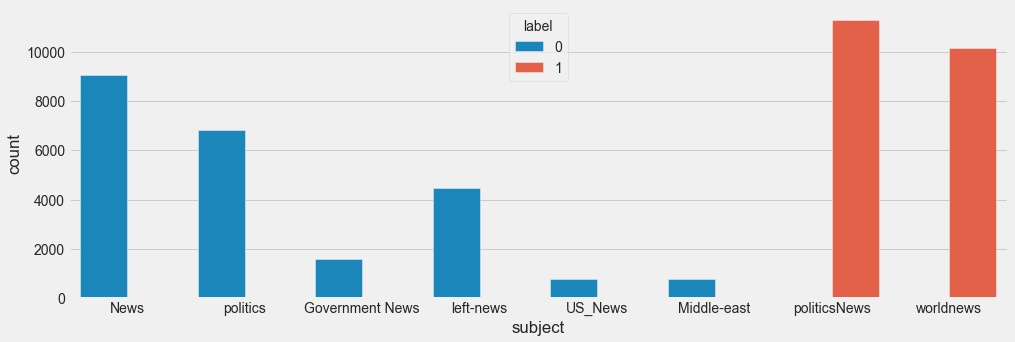

In [17]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,5))
sns.countplot(x='subject',data=df_whole,hue='label')

<AxesSubplot:>

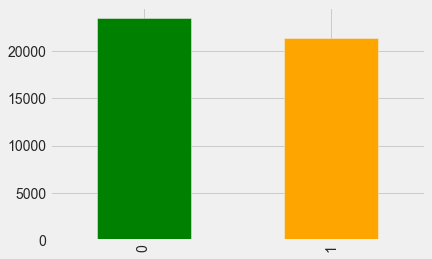

In [18]:
df_whole['label'].value_counts().plot.bar(color=['green','orange'])
# sns.countplot(x='label', data=df_whole, palette='Set3')
# plt.show()

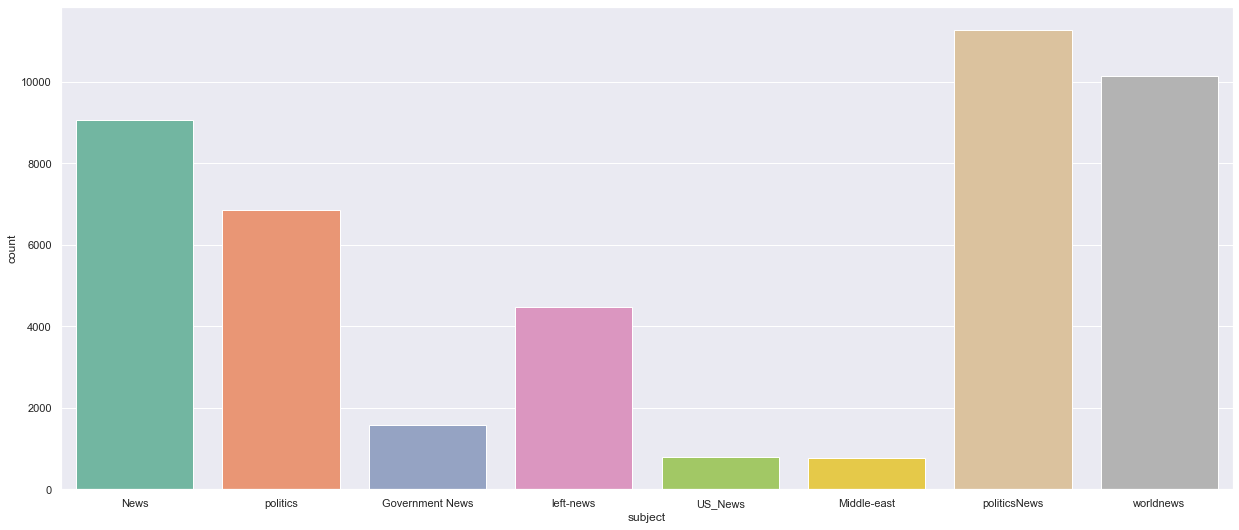

In [25]:
sns.countplot(x='subject', data=df_whole, palette='Set2')
sns.set(rc={'figure.figsize':(14.7,8.27)})
plt.show()

In [26]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_whole, test_size=0.4, shuffle=True)

In [27]:
train['text'].shape, train['label'].shape, test['text'].shape, test['label'].shape,

((26938,), (26938,), (17960,), (17960,))

In [28]:
train_data = tf.data.Dataset.from_tensor_slices((train['text'].values, train['label'].values))

In [29]:
val_data = tf.data.Dataset.from_tensor_slices((test['text'].values, test['label'].values))

In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

train_examples_batch, train_labels_batch

In [31]:
embedding = "." # "https://tfhub.dev/google/nnlm-en-dim128/2"   nnlm-en-dim128_2.tar.gz
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
hub_layer(train_examples_batch[:3])

In [41]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(512, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense_5 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

In [42]:
model_name = "model0_adam_b256_ep10.h5"

checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 4,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])   # tf.metrics.BinaryAccuracy() ) 

In [43]:
batch_size = 256

history = model.fit(train_data.shuffle(10000).batch(batch_size),
                    epochs=5,
                    callbacks = callbacks,
                    validation_data=val_data.batch(batch_size),
                    verbose=1)

Epoch 1/5
106/106 [==============================] - 374s 4s/step - loss: 0.0362 - accuracy: 0.9856 - val_loss: 0.0232 - val_accuracy: 0.9931

Epoch 00001: val_loss improved from inf to 0.02316, saving model to model0_adam_b256_ep10.h5
Epoch 2/5
106/106 [==============================] - 336s 3s/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0161 - val_accuracy: 0.9964

Epoch 00002: val_loss improved from 0.02316 to 0.01613, saving model to model0_adam_b256_ep10.h5
Epoch 3/5
106/106 [==============================] - 412s 4s/step - loss: 3.7593e-04 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 0.9965

Epoch 00003: val_loss did not improve from 0.01613
Epoch 4/5
106/106 [==============================] - 385s 4s/step - loss: 4.0318e-04 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 0.9966

Epoch 00004: val_loss did not improve from 0.01613
Epoch 5/5
106/106 [==============================] - 318s 3s/step - loss: 3.6063e-04 - accuracy: 1.0000 - val_loss: 0.0167 - val

In [44]:
results = model.evaluate(val_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

36/36 - 5s - loss: 0.0167 - accuracy: 0.9965
loss: 0.017
accuracy: 0.997


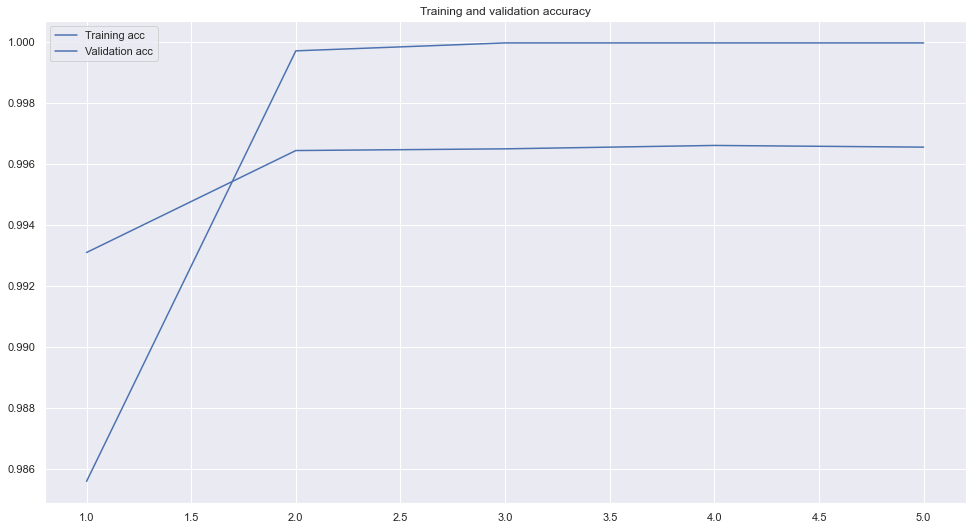

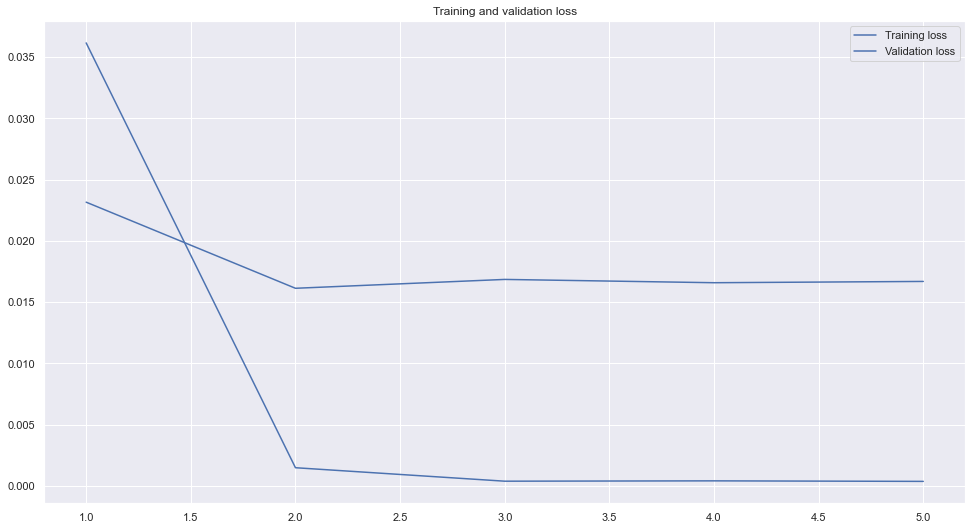

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, '-', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

0.9995255586164677


<AxesSubplot:>

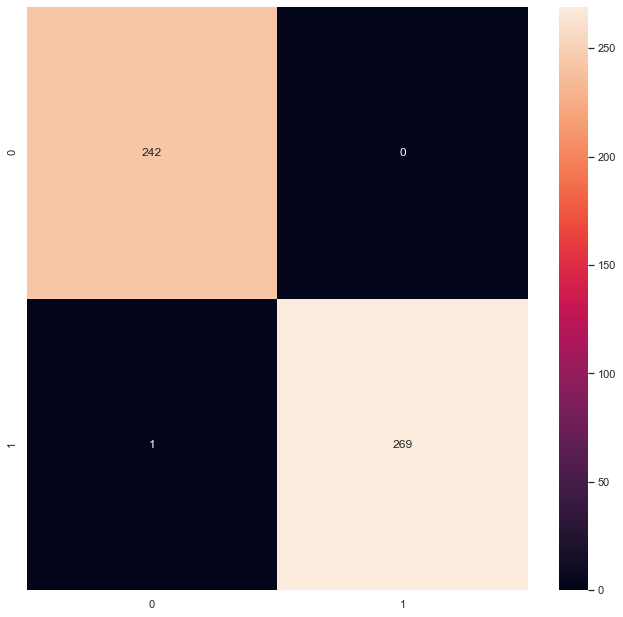

In [49]:
x_test, y_test = next(iter(val_data.batch(512)))

predicted_value = model.predict(x_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
        
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

In [56]:
x_val, y_val = next(iter(val_data.batch(1)))

In [57]:
print(f"VALIDATION TEXT : {x_val[0].numpy()}")
print("=============================")
print(f"EXPECTED OUTCOME : {y_val[0].numpy()}")

VALIDATION TEXT : b'MANILA (Reuters) - U.S. President Donald Trump raised North Korea s missile tests during talks on Monday with the prime ministers of Japan and Australia, and said  a lot  of progress had been made in negotiations on trade. On the sidelines of a summit of East and Southeast Asian leaders in Manila, Trump met with Japan s Shinzo Abe and Australia s Malcolm Turnbull, and said discussions at the meeting would include tensions on the Korean Peninsula and trade. In brief remarks prior to news media being ushered out of the meeting, Turnbull said North Korea s  recklessness  needed to be stopped, while Abe said the most immediate challenge was to ensure regional peace and stability. Following the meeting, the White House said  the three leaders reaffirmed their commitment to maintaining maximum pressure on North Korea in the effort to denuclearize the Korean Peninsula.   They also discussed expanded security cooperation for enhanced deterrence and defense against North Kor

In [58]:
# predict = model.predict(x_val, verbose=2)
predict = int(model.predict_classes(x_val)[0])
print(label_map[predict])

REAL
